*Course: Interventions and Calibrations  
Institution: Imperical College London  
Presenter: Dr. Nimalan Arinaminpathy*

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Define a helper function for plotting.

In [3]:
def plot_model(df, times):
    """
    Helper function for plotting
    Assumes df contains columns labeled S, I, R, M, V, Iv and/or T
    Returns a graph based on data in the dataframe
    """
    colors = ["b", "r", "g", "k", "y", "b", "r", "k"]
    labels = {"S":"Susceptible", "I":"Infected", "R":"Recovered",
              "M":"Deceased", "T":"Treated", "V":"Vaccinated",
              "Iv":"Infected+Vaccinated", "E":"Exposed"}
    f, ax = plt.subplots(figsize=(10,7))
    total_pop = df.iloc[0].sum()
    
    for i, col in enumerate(df.columns):
        ax.plot(times, df[col]/total_pop, colors[i], linewidth=2, label=labels[col])
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Proportion of the Population")
    ax.legend(loc="right")
    return ax.get_figure()

### 1. Extending the SIR model to model a treatment which speeds up recovery.

In epidemiology, the basic reproduction number, or basic reproductive number (sometimes called basic reproduction ratio or basic reproductive rate), denoted $R_{0}$ of an infection can be thought of as the expected number of cases directly generated by one case in a population where all individuals are susceptible to infection.

In [4]:
beta = 0.6         # infection rate (days^-1)
gamma = 0.2        # natural recovery rate (days^-1)
h = 0.25           # rate of treatment initiation (days^-1)
gamma_t = 0.8      # rate of recovery after treatment (days^-1)

follow_up_duration = 80 # number of days

state = (300000, 1, 0, 0) # susceptible, infected, recovered, treated
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, h, gamma_t)

In [5]:
def sir_model1(state, t, parameters):
    
    N = (state[0] + state[1] + state[2] + state[3]) # S+I+R+T
    lambda_ = parameters[0] * (state[1] + state[3]) / N # beta * (I+T)/N
    
    dSdt = -lambda_ * state[0]
    dIdt = lambda_ * state[0] - parameters[1] * state[1] - parameters[2] * state[1]
    dTdt = parameters[2] * state[1] - parameters[3] * state[3]
    dRdt = parameters[1] * state[1] + parameters[3] * state[3]
    
    return dSdt, dIdt, dRdt, dTdt

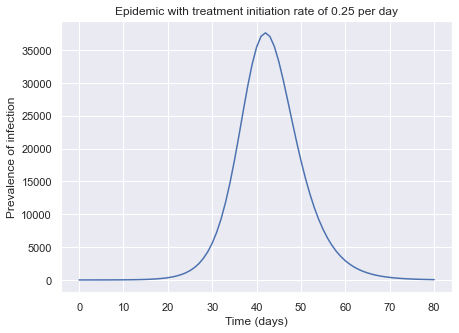

In [6]:
def run_sir_model1(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model1, state, times, (parameters,)), columns=["S", "I", "R", "T"])
    #plot_model(df, times)
    return df

df = run_sir_model1(state, times, parameters)

# Plot infected people (untreated (I) and treated (T))
plt.figure(figsize=(7,5))
plt.plot(times, df["I"]+df["T"])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence of infection")
plt.title("Epidemic with treatment initiation rate of "+str(h)+" per day");

**Q: How many people are infected at the peak of the epidemic?**

In [7]:
print("Number of infected people at peak:", round((df["I"]+df["T"]).max(),0))

Number of infected people at peak: 37615.0


**Q: How rapidly does treatment need to be initiated in order to interrupt transmission, i.e. to bring $R_{0}$ below 1? Based on this, do you think it is feasible to interrupt transmission through treatment alone?**  

h =  0.25 Number of infected people at peak: 37615.256636522085
h =  0.5 Number of infected people at peak: 16057.562558167003
h =  1.0 Number of infected people at peak: 668.6432132775209
h =  1.5 Number of infected people at peak: 2.757942049079236
h =  1.6 Number of infected people at peak: 1.1999527007252062
h =  1.7 Number of infected people at peak: 1.1711250370746635


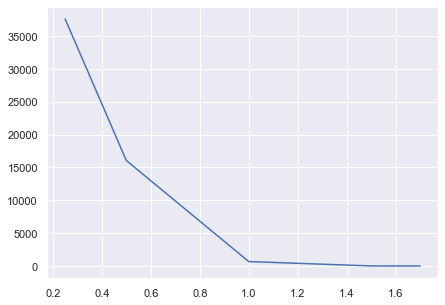

In [8]:
lst_inf = []
lst_h = [0.25, 0.5, 1.0, 1.5, 1.6, 1.7]
for h in lst_h:
    parameters = (beta, gamma, h, gamma_t)
    df = run_sir_model1(state, times, parameters)
    max_infected = (df["I"] + df["T"]).max()
    lst_inf.append(max_infected)
    print("h = ", h, "Number of infected people at peak:", max_infected)
    
plt.figure(figsize=(7,5))
plt.plot(lst_h, lst_inf);

To interrupt transmission by bringing $R_{0}$ below 1, the treatment initiation rate needs to be at least 1.6 per day, which means people need to start treatment less than a day after becoming infected on average. 

To achieve a reduction in the treatment initiation rate, think about what it depends on: the time it takes people to go to a doctor, the time it takes to get a diagnosis, and the time from diagnosis to starting treatment for example. These in turn depend on many situational aspects such as whether the disease is symptomatic, the healthcare system, which test is required for a diagnosis etc. *One way of increasing the rate of treatment initiation would be through active case-finding for example, rather than waiting for people to seek medical attention themselves.* 

However, given all these factors, achieving a treatment initiation rate as high as required in this example does not seem feasible.

**Q: Using only reasoning based on $R_{0}$ (i.e. without computer simulation), what is the minimum value of *h* needed to interrupt transmission? Is this consistent with what you found using the model in the previous question?**

Remember that $R_{0}$ is defined as the average number of secondary infections caused by a single infectious case (in a totally susceptible population). We can derive the following equation:

\begin{align}
R_0 & = \frac{\beta}{\gamma+h} + \frac{h}{\gamma+h} \times \frac{\beta}{\gamma_T}
\end{align}

Here, we are taking the average of secondary infections caused by index cases in the I and the T compartment, keeping in mind that only a proportion \begin{align} \frac{h}{\gamma+h}\end{align} move into the treatment compartment before recovering.

Solving this equation with our parameter values to obtain R<sub>0</sub> < 1:

\begin{align}
1 & > \frac{0.6}{0.2+h} + \frac{h}{0.2+h} \times \frac{0.6}{0.8} \\
\\
0.2 + h & > 0.6 + 0.75 h \\
\\
h & > 1.6
\end{align}

This is consistent with the value we found with the model in the previous question!

**Q: What other (theoretical) changes could you make to this treatment to improve its impact on the epidemic?**

In reality, the delay between people becoming infected and people starting on treatment is often the only thing that can be changed to some degree during an outbreak. However, given more time, improving the efficacy and biological action of the treatment itself is likely to improve its impact on reducing the prevalence, for example by:
- increasing the recovery rate of those on treatment
- developing a treatment that additionally reduces the infectiousness of those who take it

Keep in mind though that how the efficacy of a treatment translates into its population-level impact is not always obvious, and depends again on many other factors.

### 2. A separate compartment for vaccination.  

![V](data/m1_nb2_diagram.png)  
where:  
$S_{0} = (1 - p)N$ with $p$ being the effective vaccination coverage and $N$ the total populations size  
$I_{0} = 1$  
$R_{0} = 0$  
$V_{0} = pN$. 

In [9]:
N = 1000000
p = 0.3

S = (1-p)*N; I=1; R=0; V=p*N

beta = 0.5         # infection rate (days^-1)
gamma = 0.1        # natural recovery rate (days^-1)

follow_up_duration = 100 # number of days

state = (S, I, R, V) # susceptible, infected, recovered, vaccinated
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma)

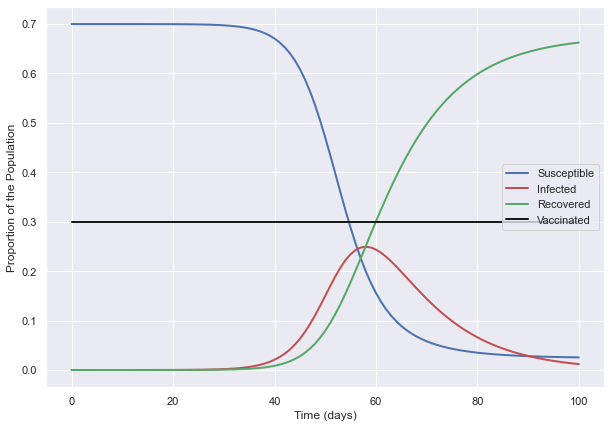

In [10]:
def sir_model2(state, t, parameters):
    
    N = (state[0] + state[1] + state[2] + state[3])
    lambda_ = parameters[0] * (state[1]) / N
    
    dSdt = -lambda_ * state[0]
    dIdt = lambda_ * state[0] - parameters[1] * state[1]
    dRdt = parameters[1] * state[1]
    dVdt = 0
    
    return dSdt, dIdt, dRdt, dVdt

def run_sir_model2(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model2, state, times, (parameters,)), columns=["S", "I", "R", "V"])
    plot_model(df, times)
    return df

df = run_sir_model2(state, times, parameters)

The code seems to gives a sensible output: 
- if we chose no or a low vaccination coverage, we see an epidemic as we would expect given our choice of $\beta$ and $\gamma$ (R<sub>0</sub> = 0.5/0.1 = 5)
- if we chose a vaccination coverage over the herd immunity threshold of 80% (> 1-1/R<sub>0</sub>), no epidemic occurs
- the proportion of the population in the vaccinated compartment $V$ stays constant over time

**Q: Why do we need to specify V in the differential equations at all?**

You might wonder why we specify the rate of change in the vaccinated compartment in our differential equations, despite this not changing over time. This is purely for practical reasons using `odeint`. Technically all we need is to define the initial number of people in $V$, but remember that using `odeint`, we need to return/output the rate of change variables at the end of the model function corresponding to the same order of variables in the initial_state_values vector. So by having $V$ in the initial conditions, we also have to output its rate of change from the model function.

### 3. Modelling a Leaky Vaccine.

Vaccination has two purposes: 1) individual protection, and 2) population or “herd” protection. If immunity (i.e., successful vaccination) were delivered at random and if members of a population mixed at random, such that on average each individual contacted $R_{0}$ individuals in a manner sufficient to transmit the infection, then incidence of the infection would decline if the proportion immune exceeded $\frac{R_{0} - 1}{R_{0}}$ or $1 - \frac{1}{R_{0}}$.

**Q: Assuming $\beta$ equals 0.25 days$^{-1}$ and $\gamma$ equals 0.1 days$^{-1}$, what proportion of the population would have to be vaccinated with a perfectly effective vaccine to prevent an epidemic?**  

Using the formula for the herd immunity threshold, we need a vaccine coverage of 60% with a perfect vaccine:

\begin{align}
p_c & = 1- \frac{1}{R_{0}} \\
    & = 1- \frac{\gamma}{\beta} \\
    & = 1 - \frac{0.1}{0.25} \\
    & = 0.6
\end{align}


**Q: Given the parameter assumptions above, what proportion of the population would have to be vaccinated with an all-or-nothing vaccine with 70% efficacy to prevent an epidemic?**  

Under the assumption of an all-or-nothing vaccine, we can simply multiply the vaccine efficacy *v<sub>eff</sub>* and the vaccine coverage to calculate the effective coverage *p<sub>eff</sub>*:

\begin{align}
v_{eff} * p_{eff} & = 0.6 \\
p_{eff} = \frac{0.6}{0.7} \\
p_{eff} = 0.86
\end{align}

Therefore, we need at least 86% coverage of a leaky vaccine with efficacy of 70%, to interrupt transmission (R<sub>0</sub> < 1).

#### A Leaky Vaccine
![Leaky Vaccine](data/leaky_vaccine.png)  

**Q: Based on the diagram, the differential equations for this model are shown below. What is the value of *c<sub>s</sub>* for a leaky vaccine with 70% efficacy?**

\begin{align}
\frac{dS}{dt} & = -\beta \frac{I}{N} S \\
\frac{dI}{dt} & = \beta \frac{I}{N} S + c_{s} \beta \frac{I}{N} V - \gamma I \\
\frac{dR}{dt} & = \gamma I \\
\frac{dV}{dt} & = -c_{s} \beta \frac{I}{N} V
\end{align}

For a leaky vaccine with 70% efficacy, the value of c<sub>s</sub> would be 0.3, reflecting the degree to which susceptibility is reduced.

**Modelling a leaky vaccine with 60% coverage**:

In [11]:
N = 1000000
p = 0.6

S = (1-p)*N; I=1; R=0; V=p*N

beta = 0.25         # infection rate (days^-1)
gamma = 0.1        # natural recovery rate (days^-1)
c_s = 0.3

follow_up_duration = 730 # number of days

state = (S, I, R, V) # susceptible, infected, recovered, vaccinated
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, c_s)

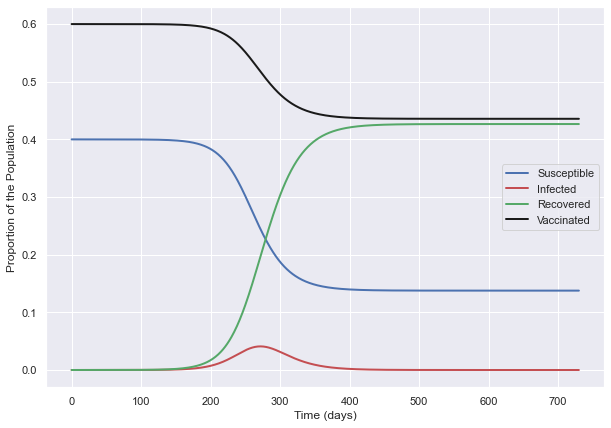

In [12]:
def sir_model3(state, t, parameters):
    
    N = (state[0] + state[1] + state[2] + state[3])
    lambda_ = parameters[0] * (state[1]) / N
    
    dSdt = -lambda_ * state[0]
    dIdt = lambda_ * state[0] - parameters[1] * state[1] + parameters[2] * lambda_ * state[3]
    dRdt = parameters[1] * state[1]
    dVdt = -c_s * lambda_ * state[3]
    
    return dSdt, dIdt, dRdt, dVdt

def run_sir_model3(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model3, state, times, (parameters,)), columns=["S", "I", "R", "V"])
    plot_model(df, times)
    return df

df = run_sir_model3(state, times, parameters)

As shown above, a 60% coverage is not sufficient to prevent an epidemic if the vaccine is not perfectly effective. 

**Modelling a leaky vaccine with 86% coverage:**

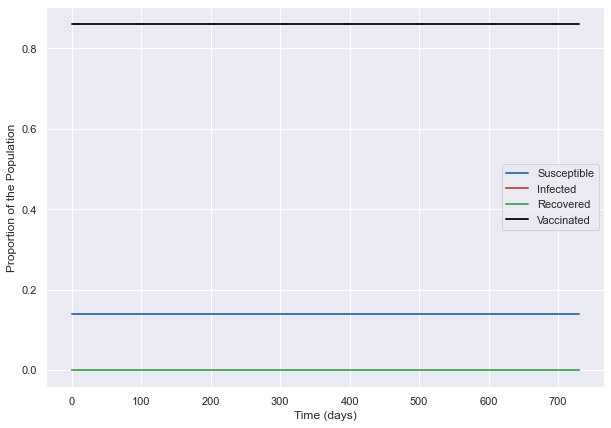

In [13]:
p = 0.86
S = (1-p)*N; I=1; R=0; V=p*N

follow_up_duration = 730 # number of days

state = (S, I, R, V) # susceptible, infected, recovered, vaccinated
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, c_s)

df = run_sir_model3(state, times, parameters)

**Q: With a leaky vaccine with 70% efficacy, what proportion of the population would have to be vaccinated to prevent an epidemic (R<sub>eff</sub> < 1)?**

The simulation above suggests that we need a coverage of at least 86% with a leaky vaccine with 70% efficacy to interrupt transmission and prevent an epidemic.

We can calculate the critical vaccination coverage needed to interrupt transmission (R<sub>eff</sub> < 1), in the following way.

Remember that in a simple homogenous model, R<sub>eff</sub> is proportional to the number of susceptible people in the population. In this case:

\begin{align}
R_{eff} & = (1-p) \times R_0 + p c_S \times R_0
\end{align}

where *p* is the proportion of the population receiving the vaccine, and c<sub>s</sub> is the reduction in susceptibility owing to the vaccine.

Setting p = p<sub>c</sub> when R<sub>eff</sub> = 1, and solving this to find *p<sub>c</sub>* gives:

\begin{align}
p_c & = \frac{1-\frac{1}{R_0}}{1-c_s} \\
p_c & = \frac{1-\frac{1}{\frac{0.25}{0.1}}}{1-0.3} \\
p_c & = 0.86
\end{align}

### 4. Modelling additional vaccine effects.

In [14]:
N = 1000000
p = 0.6

S = (1-p)*N; I=1; R=0; V=p*N; Iv=0

beta = 0.25         # infection rate (days^-1)
gamma = 0.1        # natural recovery rate (days^-1)
c_s = 0.3
c_i = 0.5

follow_up_duration = 730 # number of days

state = (S, I, R, V, Iv) # susceptible, infected, recovered, vaccinated
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, c_s, c_i)

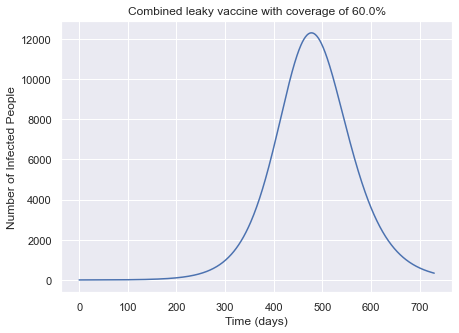

In [15]:
def sir_model4(state, t, parameters):
    
    #N = (state[0] + state[1] + state[2] + state[3] + state[4])
    lambda_ = parameters[0]*state[1]/N + parameters[3]*parameters[0]*state[4]/N
    
    dSdt = -lambda_*state[0]
    dIdt = lambda_*state[0] - parameters[1]*state[1]
    dRdt = parameters[1]*state[1] + parameters[1]*state[4]
    dVdt = -parameters[2]*lambda_*state[3]
    dIvdt = parameters[2]*lambda_*state[3] - parameters[1]*state[4]
    
    return dSdt, dIdt, dRdt, dVdt, dIvdt

def run_sir_model4(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model4, state, times, (parameters,)), columns=["S", "I", "R", "V", "Iv"])
    #plot_model(df, times)
    return df

df = run_sir_model4(state, times, parameters)

plt.figure(figsize=(7,5))
plt.plot(times, df["I"]+df["Iv"])
plt.xlabel("Time (days)")
plt.ylabel("Number of Infected People")
plt.title("Combined leaky vaccine with coverage of "+str(p*100)+"%");

**Q: What is the peak prevalence (number of infected people) with a vaccine coverage of 60%?**

The plot shows that nearly 12500 people are infected at the peak of the epidemic - this includes both vaccinated and unvaccinated people (the I and I<sub>V</sub> compartment).

**Q: For this vaccine, what is the minimum vaccination coverage required to interrupt transmission, i.e. to bring R<sub>eff</sub> below 1? Calculate this on paper, then confirm the value you derived using your model.**

We can calculate this in a similar way to the previous etivity, first relating R<sub>eff</sub> to R<sub>0</sub>:

\begin{align}
R_{eff} & = (1-p) \times R_0 + p c_s c_i \times R_0
\end{align}

Then, solving this equation for p<sub>C</sub> = *p* when R<sub>eff</sub> = 1:

\begin{align}
p_c & = \frac{1-\frac{1}{R_0}}{1- c_s \times c_i} \\
p_c & = \frac{1-\frac{1}{\frac{0.25}{0.1}}}{1- 0.3 \times 0.5} \\
p_c & = 0.71
\end{align}

That is, we need to vaccinate at least 71% of the population in order to interrupt transmission (R<sub>eff</sub> < 1).

**Modelling the minimum vaccine coverage required to interrupt transmission:**

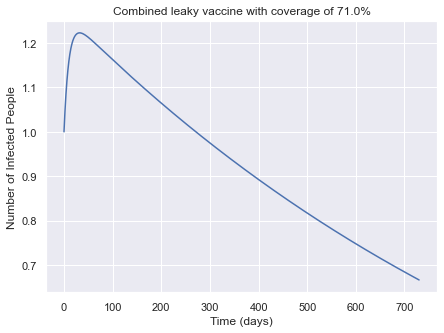

In [16]:
p=0.71
S = (1-p)*N; I=1; R=0; V=p*N; Iv=0
state = (S, I, R, V, Iv)

df = run_sir_model4(state, times, parameters)

plt.figure(figsize=(7,5))
plt.plot(times, df["I"]+df["Iv"])
plt.xlabel("Time (days)")
plt.ylabel("Number of Infected People")
plt.title("Combined leaky vaccine with coverage of "+str(p*100)+"%");

The plot above shows that, with a coverage of 71%, the number of infected people immediately goes into decline (from the 1 infected case at the beginning of the simulation).

### 5. Manual calibration of an SIR model  

The epidemic curve below shows an exponentially increasing number of infected people, which means the data corresponds to the initial growth phase of the epidemic.

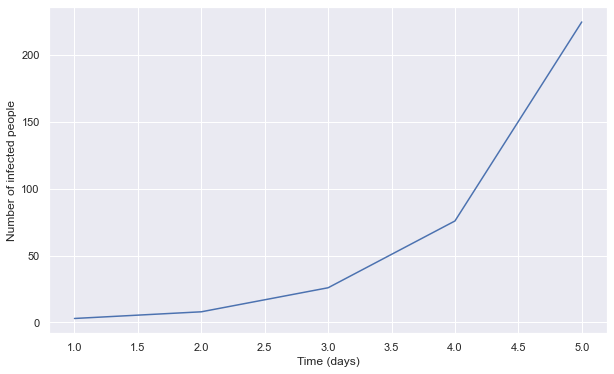

In [17]:
time = range(1,6)
number_infected = [3,8,26,76,225]
plt.figure(figsize=(10,6))
sns.lineplot(time, number_infected)
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");

**Example of the manual calibration:**

As an arbitrary choice of parameters, let's first try $\beta$ = 0.6 days$^{-1}$, and $\gamma$ = 0.1 days$^{-1}$ (remembering that we want $\beta$/$\gamma$ > 1, so that $\beta$ > $\gamma$).

In [18]:
S = 762; I=1; R=0

beta = 0.6         # infection rate (days^-1)
gamma = 0.1        # natural recovery rate (days^-1)

follow_up_duration = 5 # number of days

state = (S, I, R) # susceptible, infected, recovered, vaccinated
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma)

In [19]:
def sir_model5(state, t, parameters):
    
    N = (state[0] + state[1] + state[2])
    lambda_ = parameters[0] * (state[1]) / N
    
    dSdt = -lambda_ * state[0]
    dIdt = lambda_ * state[0] - parameters[1] * state[1]
    dRdt = parameters[1] * state[1]
    
    return dSdt, dIdt, dRdt

def run_sir_model5(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model5, state, times, (parameters,)), columns=["S", "I", "R"])
    #plot_model(df, times)
    return df

df = run_sir_model5(state, times, parameters)

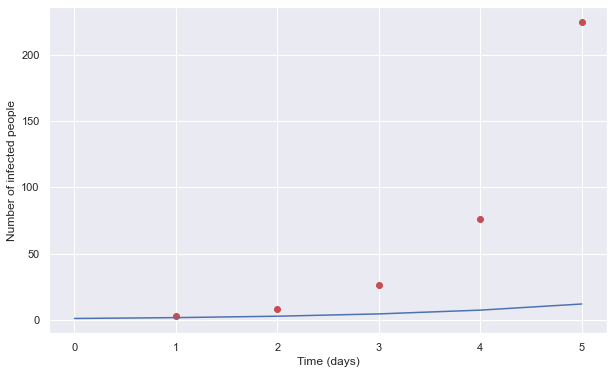

In [20]:
plt.figure(figsize=(10,6))
plt.plot(time, number_infected, marker="o", color="r", linestyle="")
plt.plot(times, df["I"])
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");

With this parameter combination, the model (blue line) strongly underestimates the growth of the epidemic (red points). Let's try increasing $\beta$ to 1.5 and reducing $\gamma$ to 0.02 to get a closer match.

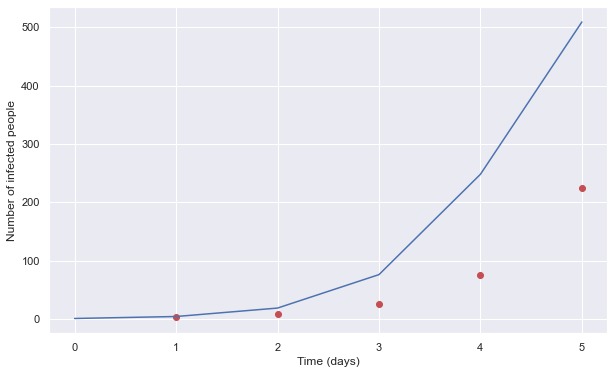

In [21]:
beta = 1.5
gamma = 0.02

parameters = (beta, gamma)
df = run_sir_model5(state, times, parameters)
plt.figure(figsize=(10,6))
plt.plot(time, number_infected, marker="o", color="r", linestyle="")
plt.plot(times, df["I"])
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");

Now we have the opposite problem. With these parameter values, the number of infected people is overestimated by the model at all but the first timepoint. Let's try reducing $\beta$ again.

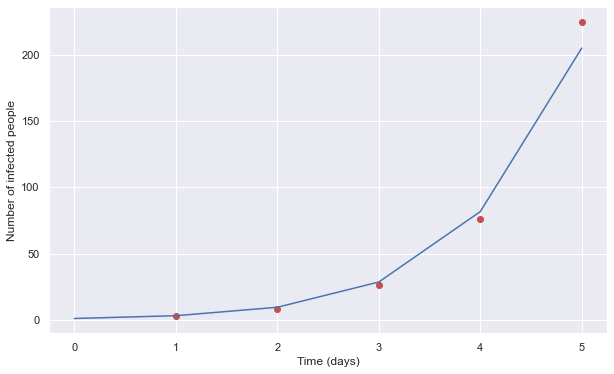

In [22]:
beta = 1.15
gamma = 0.02

parameters = (beta, gamma)
df = run_sir_model5(state, times, parameters)
plt.figure(figsize=(10,6))
plt.plot(time, number_infected, marker="o", color="r", linestyle="")
plt.plot(times, df["I"])
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");

With $\beta$ = 1.15 and $\gamma$ = 0.02 days$^{-1}$, the fit of the model prediction of the number of infected people over time to the data is looking quite good!

### 6. Manual calibration of an SIR model (using more data).

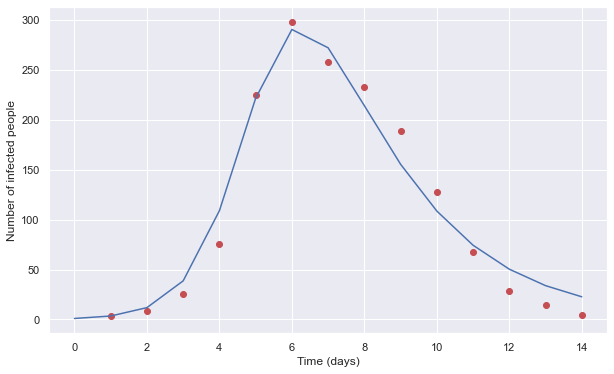

In [23]:
time = range(1,15)
number_infected = [3,8,26,76,225,298,258,233,189,128,68,29,14,4]

S = 762; I=1; R=0

beta = 1.7         # infection rate (days^-1)
gamma = 0.45        # natural recovery rate (days^-1)

follow_up_duration = 14 # number of days

state = (S, I, R) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma)

df = run_sir_model5(state, times, parameters)
plt.figure(figsize=(10,6))
plt.plot(time, number_infected, marker="o", color="r", linestyle="")
plt.plot(times, df["I"])
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");

Since this is real outbreak data, the datapoints don't neatly follow the SIR model prediction - they are for example influenced by measurement error. This means that we cannot match every single datapoint exactly, and there is some subjectivity involved in what the "best" fit looks like. For example, the model above matches the peak of the epidemic and the timing of growth and decline well, but it overestimates the number of infected people at the beginning and the end of the outbreak a little. Depending on what you consider the best visual fit, your parameter values might be slightly different to the ones presented here.

### 7. Writing a sum-of-squares function for SIR model fits

In [24]:
# Make a dataframe with data on a fictional flu epidemic
dat = pd.DataFrame(data = [3, 8, 26, 76, 225, 298, 258, 233, 189, 128, 68, 29, 14, 4],
                   index = range(1,15), columns=["I"])

In [25]:
def sir_fn(state, t, parameters):
    """
    Inputs:
      state tuple (S, I, R)
      param tuple (beta, gamma)
      list of time points
    """
    N = (state[0] + state[1] + state[2]) # S+I+R
    
    dSdt = -parameters[0] * state[0] * state[1] / N
    dIdt =  parameters[0] * state[0] * state[1] / N - (parameters[1] * state[1])
    dRdt = parameters[1] * state[1]
    
    return dSdt, dIdt, dRdt

In [26]:
def sir_SSQ(parameters, state, times, dat):
    df = pd.DataFrame(odeint(sir_fn, state, times, (parameters,)), columns=["S", "I", "R"])
    df.dropna(axis=0, inplace=True) # use only complete cases
    l = [x for x in np.array(df.index) if x in np.array(dat.index)] # get matching times
    deltas = np.square(df.iloc[l[0]:]["I"] - dat["I"])
    SSQ = np.sum(deltas)
    return SSQ

follow_up_duration = 14
state = (S, I, R)
times = list(range(0, follow_up_duration+1))

beta = 1.15
gamma = 0.02
parameters = (beta, gamma)
SSQ = sir_SSQ(parameters, state, times, dat)
print("SSQ:", SSQ, "where beta =", beta, "and gamma =", gamma)

beta = 1.7
gamma = 0.45
parameters = (beta, gamma)
SSQ = sir_SSQ(parameters, state, times, dat)
print("SSQ:", SSQ, "where beta =", beta, "and gamma =", gamma)

SSQ: 2507764.182326802 where beta = 1.15 and gamma = 0.02
SSQ: 4630.2894802558885 where beta = 1.7 and gamma = 0.45


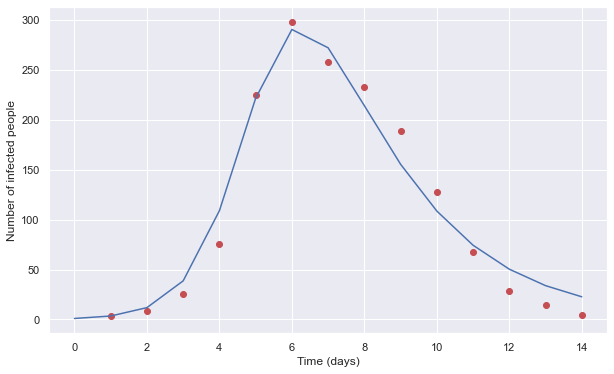

In [27]:
plt.figure(figsize=(10,6))
plt.plot(time, dat["I"], marker="o", color="r", linestyle="")
plt.plot(times, df["I"])
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");

### 8. Automated Least-Squares Calibration

In [28]:
from scipy.optimize import minimize

In [29]:
dat = pd.DataFrame(data = [3, 8, 26, 76, 225, 298, 258, 233, 189, 128, 68, 29, 14, 4],
                   index = range(1,15), columns=["I"])

beta_start = 1.
gamma_start = 0.5

S = 762; I=1; R=0

follow_up_duration = 14

state = (S, I, R)
times = list(range(0, follow_up_duration+1))
parameters = (beta_start, gamma_start)

Note that the function used for optimization, `sir_SSQ` **must** a return a scalar, the initial best guess must be the second parameter in the call to `minimize` and any additional arguments are passed in with `args=`.

In [30]:
minimize(sir_SSQ, parameters, args=(state, times, dat))

      fun: 4121.941259379239
 hess_inv: array([[2.08635816e-08, 2.59214196e-08],
       [2.59214196e-08, 3.22054277e-08]])
      jac: array([0.01501465, 0.00628662])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 432
      nit: 13
     njev: 105
   status: 2
  success: False
        x: array([1.66922612, 0.44345019])

Use optimized parameters in an SIR model

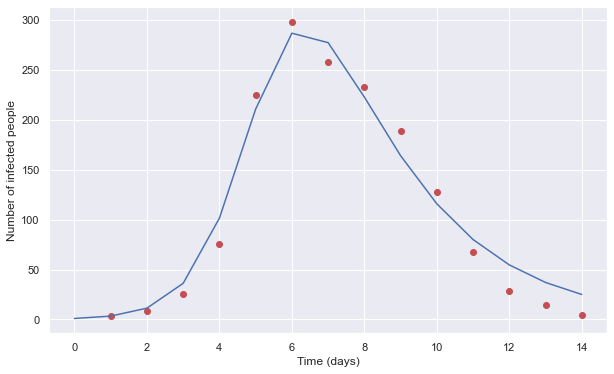

In [31]:
parameters = (1.669, 0.443)
df = pd.DataFrame(odeint(sir_fn, state, times, (parameters,)), columns=["S", "I", "R"])
plt.figure(figsize=(10,6))
plt.plot(time, dat["I"], marker="o", color="r", linestyle="")
plt.plot(times, df["I"])
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");

### 9. How Calibrations Inform Policy  

In many practical applications of modeling, we don't know the values of all the parameters. To determine the impact of interventions on an epidemic using mathematical modeling and to inform policy, we first need to estimate the parameter values from the available data, such as the prevalence of infection. Then, we can use the inferred parameter values to make projections about the effect of different interventions.  

Below we will load a new dataset of the prevalence of infection for an outbreak that lasted 200 days, in a population of 500 people and attempt to answer the following questions:

**Q1: What are the best-fitting values for $\beta$ and $\gamma$?**

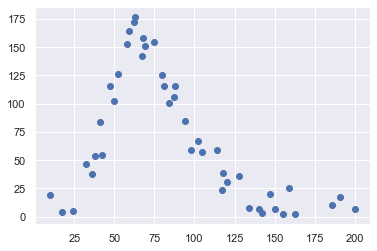

In [32]:
df_epidemic = pd.read_csv("data/m3_nb3_data.csv")
plt.scatter(df_epidemic['time'], df_epidemic['number_infected'], marker='o');

In [33]:
state = (499, 1, 0)
follow_up_duration = 200
parameters = (0.1, 0.1)
times = list(range(0, follow_up_duration+1))
df_epidemic.set_index('time', inplace=True)
df_epidemic.columns = ['I']

In [34]:
minimize(sir_SSQ, parameters, args=(state, times, df_epidemic))

      fun: 5160.718130686652
 hess_inv: array([[9.90116005e-09, 3.15993996e-09],
       [3.15993996e-09, 3.64502038e-09]])
      jac: array([0.17901611, 0.05914307])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 200
      nit: 9
     njev: 45
   status: 2
  success: False
        x: array([0.1603592 , 0.04973615])

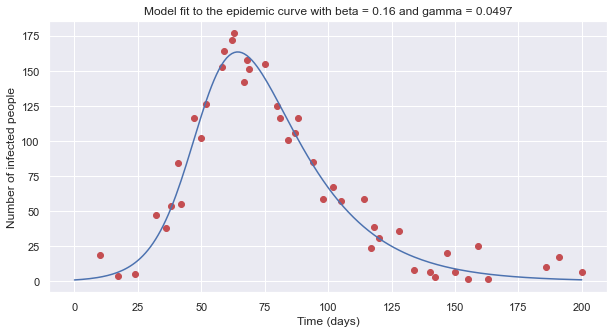

In [35]:
beta = 0.16
gamma = 0.0497
parameters = (beta, gamma)
df = pd.DataFrame(odeint(sir_fn, state, times, (parameters,)), columns=["S", "I", "R"])
plt.figure(figsize=(10,5))
plt.scatter(df_epidemic.index.values, df_epidemic['I'], marker='o', color='r');
plt.plot(df.index.values, df['I']);
plt.title("Model fit to the epidemic curve with beta = " + str(beta) + " and gamma = " + str(gamma))
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");

 **Q2: Based on the estimated parameter values, what would be the critical vaccination threshold required to prevent this epidemic, assuming an all-or-nothing vaccine with 75% efficacy?**

In [36]:
beta = 0.16
gamma = 0.05
P_eff = 1 - 1 / (beta/gamma)
print("Effective vaccination coverage:", round(P_eff,2))
v_eff = 0.75 # effectiveness of an all-or-nothing vaccine
P_c = P_eff/v_eff
print("Critical vaccination threshold:", round(P_c,2))

Effective vaccination coverage: 0.69
Critical vaccination threshold: 0.92


### 10. Performing maximum likelihood estimation  

First, load the dataset with the reported number of cases over time.

In [37]:
from scipy.stats import poisson

In [38]:
def sir_fn2(state, times, parameters):
    """
    Inputs:
      state tuple (S, I, R)
      param tuple (beta, gamma)
      list of time points
    """
    N = (state[0] + state[1] + state[2]) # S+I+R
    lambda_ = parameters[0] * state[1] / N
    
    dSdt = -lambda_ * state[0]
    dIdt =  lambda_ * state[0] - parameters[1] * state[1]
    dRdt =  parameters[1] * state[1]
    
    return dSdt, dIdt, dRdt

In [39]:
df_reported_data = pd.read_csv('data/idm2_sir_reported_data.csv')
df_reported_data.set_index('time', inplace=True)
df_reported_data.columns = ['I']

In [40]:
state = (762, 1, 0)
follow_up_duration = 14
beta = 1.; gamma = 0.1
parameters = (beta, gamma)
times = list(range(0, follow_up_duration+1))

In [45]:
def log_like(parameters, state, times, dat):
    """
    Calculate log-likelihood accounting for the reporting rate of 60%
    """
    df = pd.DataFrame(odeint(sir_fn2, state, times, (parameters,)), columns=["S", "I", "R"])
    df.dropna(axis=0, inplace=True) # use only complete cases
    l = [x for x in np.array(df.index) if x in np.array(dat.index)] # get matching times
    LL = np.sum(np.log(poisson.cdf(df.loc[l]["I"], 0.6*dat.loc[l]["I"])))
    return -LL

log_like(parameters, state, times, df_reported_data)

0.03442369922933807

In [46]:
minimize(log_like, parameters, args=(state, times, df_reported_data))

      fun: 0.03442369922933807
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.692, 0.476])

Load the real data of reported cases.

In [43]:
full_data = pd.read_csv("data/idm2_sir_data.csv")
full_data.set_index('time', inplace=True)
full_data.columns = ['I']

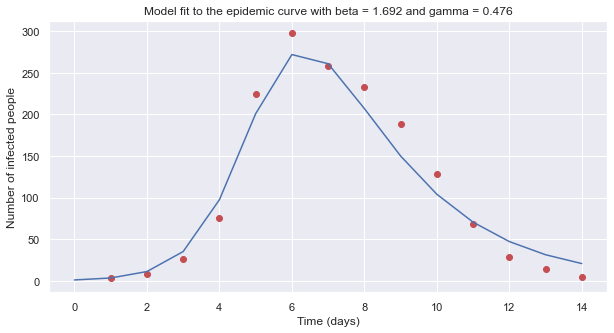

In [44]:
beta = 1.692 # expected maximized beta
gamma = 0.476 # expected maximized gamma
parameters = (beta, gamma)
df = pd.DataFrame(odeint(sir_fn, state, times, (parameters,)), columns=["S", "I", "R"])
plt.figure(figsize=(10,5))
plt.scatter(full_data.index.values, full_data['I'], marker='o', color='r');
plt.plot(df.index.values, df['I']);
plt.title("Model fit to the epidemic curve with beta = " + str(beta) + " and gamma = " + str(gamma))
plt.xlabel("Time (days)")
plt.ylabel("Number of infected people");